# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 


### TODO items

* better graphs
* load netcdf files directly (currently loads numpy files)



In [1]:
from IPython import display

import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable

import cv2
#from skimage.metrics import structural_similarity as ssim
import copy


In [6]:
# define internal pic res
ires = 16
res = 128
nvars = 8
mnvars = 8*1 +1


# Load output gridmet data (to verify agaist if wanted)

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 



nvars = 8
mb = 4      # minibatch size

# load files
d = np.load('/glade/work/dkorytin/srgan_data/prec128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv2 = np.load('/glade/work/dkorytin/srgan_data/tmax128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv3 = np.load('/glade/work/dkorytin/srgan_data/tmin128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv4 = np.load('/glade/work/dkorytin/srgan_data/uas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv5 = np.load('/glade/work/dkorytin/srgan_data/vas128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv6 = np.load('/glade/work/dkorytin/srgan_data/huss128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv7 = np.load('/glade/work/dkorytin/srgan_data/rsds128_gridmetB_1979-2016.npy')[istart:istart+ndays]
dv8 = np.load('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.npy')[istart:istart+ndays]

# Find min/max for each variable
v1max = d.max(); v1min = d.min()
v2max = dv2.max(); v2min = dv2.min()
v3max = dv3.max(); v3min = dv3.min()
v4max = dv4.max(); v4min = dv4.min()
v5max = dv5.max(); v5min = dv5.min()
v6max = dv6.max(); v6min = dv6.min()
v7max = dv7.max(); v7min = dv7.min()
v8max = dv8.max(); v8min = dv8.min()


print("v1 max/min", v1max, v1min)
print("v2 max/min", v2max, v2min)
print("v3 max/min", v3max, v3min)
print("v4 max/min", v4max, v4min)
print("v5 max/min", v5max, v5min)
print("v6 max/min", v6max, v6min)
print("v7 max/min", v7max, v7min)
print("v8 max/min", v8max, v8min)



v1 max/min 518.7773 0.0
v2 max/min 49.037712 -34.785778
v3 max/min 33.991703 -46.725536
v4 max/min 19.132183 -19.009077
v5 max/min 17.8808 -18.086332
v6 max/min 0.024878306 0.0
v7 max/min 447.97797 0.0
v8 max/min 1.0 0.0


# Load input data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################

# load eraionmpi
#mndays = 11688      # 1979-2010
mstart = 365
mndays = 13515       # 1980-2016 
#mnvars = 8*4
mnvars = 8*1
md = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv2 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv3 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv4 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv5 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv6 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv7 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]
mdv8 = np.load('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.npy')[mstart:mstart+mndays*1]

print("Days loaded", len(mdv7))

# Find min/max for each variable
mv1max = md.max(); mv1min = md.min()
mv2max = mdv2.max(); mv2min = mdv2.min()
mv3max = mdv3.max(); mv3min = mdv3.min()
mv4max = mdv4.max(); mv4min = mdv4.min()
mv5max = mdv5.max(); mv5min = mdv5.min()
mv6max = mdv6.max(); mv6min = mdv6.min()
mv7max = mdv7.max(); mv7min = mdv7.min()
mv8max = mdv8.max(); mv8min = mdv8.min()
print("mv1 max/min", mv1max, mv1min)
print("mv2 max/min", mv2max, mv2min)
print("mv3 max/min", mv3max, mv3min)
print("mv4 max/min", mv4max, mv4min)
print("mv5 max/min", mv5max, mv5min)
print("mv6 max/min", mv6max, mv6min)
print("mv7 max/min", mv7max, mv7min)
print("mv8 max/min", mv8max, mv8min)

mndays = len(mdv8)    #//4
print("mndays", mndays)

# synthetically create 16x16 input samples via bilinear scaling
dd=[]
ddo=[]
for ii in range(mndays):
    # input samples
    rowdd = []
    for iii in [0]: #range(4):
    #for iii in range(4):
       rowdd.append( cv2.resize(md[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv2[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv3[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv4[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv5[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv6[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv7[ii*1+iii],(16,16)) )
       rowdd.append( cv2.resize(mdv8[ii*1+iii],(16,16)) )
       # add doy
       rowdd.append( np.ones((16,16),dtype=np.float32)*np.cos(ii/365.25*3.14159*2.)/2. +0.5)

       dd.append(rowdd)

    # output samples
    rowddo = []
    rowddo.append( d[ii] )
    rowddo.append( dv2[ii] )
    rowddo.append( dv3[ii] )
    rowddo.append( dv4[ii] )
    rowddo.append( dv5[ii] )
    rowddo.append( dv6[ii] )
    rowddo.append( dv7[ii] )
    rowddo.append( dv8[ii] )
    ddo.append(rowddo)
    
# add channel for cos
mnvars = 9

d = np.array(dd)
do = np.array(ddo)
print("d, do, md",d.shape, do.shape, np.array(md).shape)




Days loaded 13515
mv1 max/min 29.960123 -32.7581
mv2 max/min 30.62581 -32.324654
mv3 max/min 0.017681489 4.8779977e-05
mv4 max/min 294.80206 228.65608
mv5 max/min 3278.9453 2396.74
mv6 max/min 6005.7915 4669.179
mv7 max/min 98.96818 -43.84638
mv8 max/min 75.44277 -83.25877
mndays 13515
d, do, md (13515, 9, 16, 16) (13515, 8, 128, 128) (13515, 18, 18)


In [9]:
# cast samples into tensors

# input samples
samples = []
print("ndays, mndays", ndays, mndays)
for t in range(ndays):
    samples.append(d[t])
samples = torch.tensor(np.reshape(samples, (ndays, mnvars, ires, ires)))

# output samples
osamples = []    # 20x20 samples
for t in range(ndays):
    osamples.append(do[t])
osamples = torch.tensor(np.reshape(osamples, (ndays, nvars, res, res)))
print("osamples max min",osamples.max(), osamples.min())

# debug
np.save("delme.npy", samples[0,2])
#np.save("delme.npy", mdv3[0])
print("DONEDONE\n\n", mdv3[0][0].shape)


ndays, mndays 13515 13515
osamples max min tensor(518.7773) tensor(-46.7255)
DONEDONE

 (18,)


In [10]:
##################################
## convert in batches of 1 #000 ##
##################################
downscaled_imgs = np.zeros((ndays,nvars,res,res))

#input_img = samples[0:1].cuda()
#print("input_img", input_img.shape)
#corrected_img = generator(input_img).data.cpu() 
#print("corrected_img", corrected_img.shape)

mb = 1

xplot = []
yplot = []
ymulti = []
raininput = torch.zeros(9,16,16)
dryinput = torch.zeros(9,16,16)
raincount = 0
drycount = 0
#for ii in range(0,mndays,mb):
for ii in range(0,11688,1):
    doy = ii % 365.25
    #if doy >= 0 and doy <= 30:      # Dec
    if doy >= 120 and doy <= 150:   # May
        #input_img = samples[ii:ii+mb].cuda()
        isample = samples[ii]
        osample = osamples[ii]

        #mpr = dn(generated_img[:,0,:,:]).mean()
        mpr = osample[0,35:60,42:75].mean()
        print ("day, doy, mpr (mm/day)", ii, doy, mpr)
        if mpr > 1:
            raininput += isample
            raincount += 1
        if mpr < .3:
            dryinput += isample
            drycount += 1

        #print("generated_img", generated_img.shape)
        #downscaled_imgs[ii:ii+mb] = generated_img[0:mb].data.cpu()
        #print("corrected_img", downscaled_imgs.shape)

raininput /= raincount
dryinput /= drycount


day, doy, mpr (mm/day) 120 120.0 tensor(4.3592)
day, doy, mpr (mm/day) 121 121.0 tensor(5.9995)
day, doy, mpr (mm/day) 122 122.0 tensor(4.3184)
day, doy, mpr (mm/day) 123 123.0 tensor(0.2880)
day, doy, mpr (mm/day) 124 124.0 tensor(0.3341)
day, doy, mpr (mm/day) 125 125.0 tensor(1.2186)
day, doy, mpr (mm/day) 126 126.0 tensor(1.6428)
day, doy, mpr (mm/day) 127 127.0 tensor(3.1738)
day, doy, mpr (mm/day) 128 128.0 tensor(2.1600)
day, doy, mpr (mm/day) 129 129.0 tensor(0.1090)
day, doy, mpr (mm/day) 130 130.0 tensor(0.1710)
day, doy, mpr (mm/day) 131 131.0 tensor(3.4863)
day, doy, mpr (mm/day) 132 132.0 tensor(3.5888)
day, doy, mpr (mm/day) 133 133.0 tensor(1.0108)
day, doy, mpr (mm/day) 134 134.0 tensor(11.6238)
day, doy, mpr (mm/day) 135 135.0 tensor(36.2667)
day, doy, mpr (mm/day) 136 136.0 tensor(2.9194)
day, doy, mpr (mm/day) 137 137.0 tensor(1.9020)
day, doy, mpr (mm/day) 138 138.0 tensor(6.3332)
day, doy, mpr (mm/day) 139 139.0 tensor(0.5137)
day, doy, mpr (mm/day) 140 140.0 tenso

day, doy, mpr (mm/day) 4511 128.0 tensor(0.0865)
day, doy, mpr (mm/day) 4512 129.0 tensor(1.2245)
day, doy, mpr (mm/day) 4513 130.0 tensor(3.9949)
day, doy, mpr (mm/day) 4514 131.0 tensor(11.4496)
day, doy, mpr (mm/day) 4515 132.0 tensor(1.4619)
day, doy, mpr (mm/day) 4516 133.0 tensor(1.1494)
day, doy, mpr (mm/day) 4517 134.0 tensor(6.5673)
day, doy, mpr (mm/day) 4518 135.0 tensor(2.4034)
day, doy, mpr (mm/day) 4519 136.0 tensor(4.3464)
day, doy, mpr (mm/day) 4520 137.0 tensor(6.8796)
day, doy, mpr (mm/day) 4521 138.0 tensor(4.9144)
day, doy, mpr (mm/day) 4522 139.0 tensor(5.0526)
day, doy, mpr (mm/day) 4523 140.0 tensor(6.6760)
day, doy, mpr (mm/day) 4524 141.0 tensor(3.8275)
day, doy, mpr (mm/day) 4525 142.0 tensor(5.3539)
day, doy, mpr (mm/day) 4526 143.0 tensor(4.8154)
day, doy, mpr (mm/day) 4527 144.0 tensor(2.3481)
day, doy, mpr (mm/day) 4528 145.0 tensor(6.0819)
day, doy, mpr (mm/day) 4529 146.0 tensor(0.4839)
day, doy, mpr (mm/day) 4530 147.0 tensor(7.5680)
day, doy, mpr (mm/d

day, doy, mpr (mm/day) 8913 147.0 tensor(5.8419)
day, doy, mpr (mm/day) 8914 148.0 tensor(2.7962)
day, doy, mpr (mm/day) 8915 149.0 tensor(0.9153)
day, doy, mpr (mm/day) 8916 150.0 tensor(2.3718)
day, doy, mpr (mm/day) 9252 120.75 tensor(0.7863)
day, doy, mpr (mm/day) 9253 121.75 tensor(3.1807)
day, doy, mpr (mm/day) 9254 122.75 tensor(2.1250)
day, doy, mpr (mm/day) 9255 123.75 tensor(2.2900)
day, doy, mpr (mm/day) 9256 124.75 tensor(0.2413)
day, doy, mpr (mm/day) 9257 125.75 tensor(0.0928)
day, doy, mpr (mm/day) 9258 126.75 tensor(0.3702)
day, doy, mpr (mm/day) 9259 127.75 tensor(4.1032)
day, doy, mpr (mm/day) 9260 128.75 tensor(0.2871)
day, doy, mpr (mm/day) 9261 129.75 tensor(0.1851)
day, doy, mpr (mm/day) 9262 130.75 tensor(0.0690)
day, doy, mpr (mm/day) 9263 131.75 tensor(3.3599)
day, doy, mpr (mm/day) 9264 132.75 tensor(10.9735)
day, doy, mpr (mm/day) 9265 133.75 tensor(2.5298)
day, doy, mpr (mm/day) 9266 134.75 tensor(1.6876)
day, doy, mpr (mm/day) 9267 135.75 tensor(0.0074)
day

# Plots

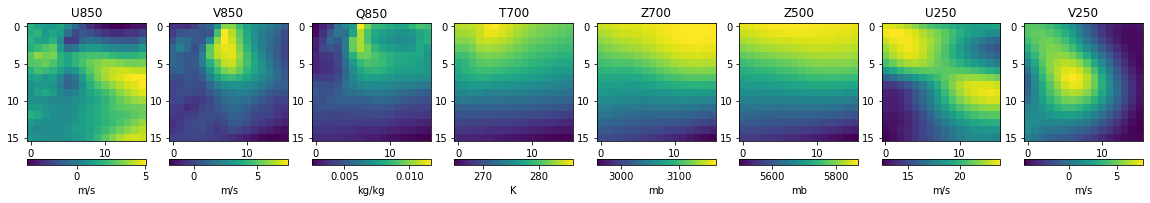

In [61]:
# plot average rain inputs
varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    plot = axarr[ii].imshow(raininput[ii])
    cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
    cbar.set_label(units[ii])
    axarr[ii].set_title(varmames[ii])
    


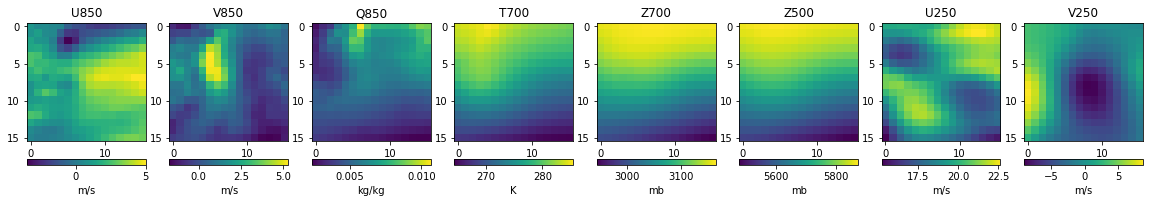

In [62]:
# plot average dry inputs
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(1, 8, figsize = (20,20))
for ii in range(8):
    plot = axarr[ii].imshow(dryinput[ii])
    cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
    cbar.set_label(units[ii])
    axarr[ii].set_title(varmames[ii])


In [48]:
# what about the cos() channel
print(raininput[8].mean(), dryinput[8].mean())

tensor(0.1592) tensor(0.1678)
